### Model

A Model here consists of a succession of layers.

Each layer is implemented as a class with the following API-methods:

- `forward(torch.tensor)`: Computes the forward pass through the layer, i.e. $x\rightarrow a$<br> and keeps the information needed for computing the backward pass as member variables. 

- `backward(torch.tensor)`: Computes the backward pass through the layer in form of the derivatives, i.e. $da \rightarrow dx$. On the fly, it also computes the derivatives w.r.t. the parameters of the layer and keeps them as member variables. It assumes that `forward` method has been run before. <br>

- `update(lr)`: Updates the parameters of the layer in accordance with vanilla gradient descent and scalar learning rate `lr`. It assumes that the `forward` and the `backward`-pass has been run before.  

The tensors defined as inputs to the `forward`/`backward`-method are two dimensional with the sample index in the first dimensionand the the feature index in the second. 

For fully connected layers with activation function $s(\cdot)$ the formulas are given as follows:

__Forward path:__

$X_{i,j}$: Tensor with shape $(n_b,n_x)$ where $n_b$ is the number of samples in the batch and $n_x$ the number of input features (for MNIST: 784).

$Z_{i,j} = \sum_k X_{i,k} W_{j,k} \qquad (Z = X \cdot W^T + b)$ $\qquad$ ($W$ a tensor of shape $(n_h,n_x)$)

$n_h$ is the number of outputs for that layer

$A_{i,j} = s(Z_{i,j}) \qquad\qquad (A = s(Z))$

__Backward path:__ (with $n_b$ the number of samples in a batch)

For specific sample $i$ and neuron $k$:

$dx_{i,k} = \frac{\partial L}{\partial x_{i,k}} = \sum_j \frac{\partial L}{\partial a_{i,j}} \frac{\partial a_{i,j}}{\partial x_{i,k}} = \sum_j da_{i,j} s^\prime(z_{i,j})\cdot \frac{\partial z_{i,j}}{\partial x_{i,k}} = \sum_j da_{i,j} s^\prime(z_{i,j}) W_{j,k}$ $ \quad$ where $\quad \frac{\partial L}{\partial a_{i,j}} = da_{i,j}$ <br>

$dW_{j,k} = \frac{\partial L}{\partial W_{j,k}} = \frac{1}{n_b}\sum_{i,l} dA_{i,l}\frac{\partial A_{i,l}}{\partial W_{j,k}} = \frac{1}{n_b}\sum_{i,l} dA_{i,l} s^\prime(Z_{i,l}) \delta_{j,l} X_{i,k} = \frac{1}{n_b}\sum_{i} dA_{i,j} s^\prime(Z_{i,j}) X_{i,k} $<br>

Indices:
- i: Sample
- j: Feature
- k: Neuron within layer



__Parameter Initialisation__ 

The parameters need to be initialised which will be a topic later in the course. For now use the following rules: 
* weights normally distributed with mean $0$ and stdev $1/\sqrt{n_h}$
* bias initialized with zero values

#### <span style="color:red">Important Note on the Implementation</span>

Make sure that all the tensors used anywhere in the model components below have `requires_grad=False` (default value).
Autograd functionality is not allowed for computing the gradients. - Autograd will be used below for testing whether your implementation is correct.

In [24]:
import math
import numpy as np
import torch
import torchvision

In [25]:
torch.cuda.is_available()

True

### Linear Layer

In [26]:
class LinearLayer():
    def __init__(self, nx, nh):
        """
        nx -- number of input features, i.e. shape of input tensors x given by (*,nb_input)
        nh -- number of output features, i.e. shape of output tensor z given by (*,nb_hidden)
        """    
        self.nx = nx
        self.nh = nh
        self.w = torch.empty(nh, nx).normal_(0, 1./math.sqrt(self.nh))
        self.b = torch.zeros(nh)
        self.dw = torch.zeros_like(self.w)
        self.db = torch.zeros_like(self.b)
        self.x = None
        self.dx = None
    
    def forward(self, x):
        """
        Computes the forward pass through the layer (x -> z)
        x -- input tensor
        returns z 
        """
        ### YOUR CODE START ###
        z = x@self.w.T + self.b
        self.x = x # save for dx computation in backward() method
        return z
        ### YOUR CODE END ###
    
    def backward(self, dz):
        """
        Computes the backward pass through the layer incl. the derivatives w.r.t. input x (dx), weight w (dw) and bias b (db).
        dz -- tensor with the backprop'd error signal with the same shape as z.         
        returns dx
        """
        assert len(dz.shape)==2 and dz.shape[1] == self.nh
        ### YOUR CODE START ###
        dx = dz@self.w # equivalent to dx = inv(W)@dz
        self.dx = dx
        
        self.dw = dz.T @ self.x
        self.db = torch.sum(dz, dim=0)

        return dx
        ### YOUR CODE END ###
            
    def update(self, lr):
        """
        Updates the parameters of the model (weights w and bias b) with the gradient w.r.t. w and b and learning rate.
        returns None
        """
        ### YOUR CODE START ###
        self.w -= lr * self.dw
        self.b -= lr * self.db
        ### YOUR CODE END ###



<span style="color:blue">SHAPE TEST:</span>

In [27]:
linear = LinearLayer(3,4)
assert (4,3) == linear.w.shape
assert (4,)  == linear.b.shape

x = torch.tensor([[1.,2,3],
                  [4,5,6]])
a = linear.forward(x)
assert (2,4) == a.shape

dz = torch.tensor([[1.,1,1,1],
                   [2.,2,2,2]])
dx = linear.backward(dz)
assert (2,3) == dx.shape
assert (4,3) == linear.dw.shape

### Activation Function

__Sigmoid__

In [28]:
def s(x):
    x_norm = torch.sign(x) * torch.clamp(torch.abs(x), 1e-4, 70)
    return torch.exp(x_norm)/(1+torch.exp(x_norm))

In [29]:
class SigmoidActivation():

    def __init__(self):
        self.z = None
    
    def forward(self, z):
        ### YOUR CODE START ###
        a = s(z)
        self.z=z # track input to get derivative at this point in backward pass
        return a
        ### YOUR CODE END ###

    def backward(self, da):
        """ Takes da = dL/da and adds on sigmoid derivative s(z0)*(1-s(z0)) """
        ### YOUR CODE START ###
        dz = da * s(self.z) * (1 - s(self.z))
        
        return dz
        ### YOUR CODE END ###
            
    def update(self, lr):
        ### YOUR CODE START ###
        # No params to update
        pass
        
        ### YOUR CODE END ###


### Model

Now implement an MLP as a succession of layers - linear layers and non-linear activation layers.
For creating an instance, you will pass the following arguments: 
* __nx__: number of input features
* __nunits__: _list_ of number of units in the hidden layers _including the output layer_

Add a list of layers as member variable.

Use just a linear layer at the end. Further below we will use a CE loss which is based on the finally output logit values (see lecture of week 2) where the softmax probabilities are implicit.

In [32]:
class MLP():
    
    def __init__(self, nx, nunits):
        self.nx = nx
        self.nlayers = len(nunits)
        self.nunits = nunits
        self.nunits.insert(0,nx)
        self.nclasses = self.nunits[-1]
        self.layers = []
        
        ### YOUR CODE START ###
        # instantiate the different layers (linear and activations)
        for l in range(self.nlayers):
            if l==0:
                self.layers.append(LinearLayer(nx, nunits[l+1])) 
            else:
                self.layers.append(LinearLayer(nunits[l], nunits[l+1])) 
      
            self.layers.append(SigmoidActivation())
        
        self.layers.pop() # pop sigmoid layer off of output stage
        ### YOUR CODE END ###

        
    def forward(self, x):
        """
        x - input tensor        
        returns output tensor of the model
        """
        
        ### YOUR CODE START ###
        prev_layer_ouput = x
        for layer in self.layers:
            prev_layer_ouput = layer.forward(prev_layer_ouput)
        
        last_layer_output = prev_layer_ouput
        return last_layer_output
        ### YOUR CODE END ###
    
    def backward(self, dy):
        """
        dy - derivative (of Loss) w.r.t. output tensor
        
        returns derivative with respect to the input tensor of the model; 
        on the fly compute all the derivatives w.r.t. parameters of the model
        """        
        ### YOUR CODE START ###
        
        gradient = dy
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
        
        dx = gradient
        return dx
        ### YOUR CODE END ###
    
    def update(self, lr):
        """
        Update the parameters with the given (stored) derivatives w.r.t. model parameters by using the given learning rate. 
        """
        ### YOUR CODE START ###
        for layer in self.layers:
            layer.update(lr)
            
        
        
        ### YOUR CODE END ###
            

<span style="color:blue">SHAPE TEST:</span>

In [33]:
nx = 2
nunits = [3,4]
mlp = MLP(nx,nunits)
assert 3 == len(mlp.layers)

x = torch.tensor([[1.,2],
                  [3,4]])
a = mlp.forward(x)
assert (2,4) == a.shape

da = torch.tensor([[1.,1,1,1],
                   [2.,2,2,2]])
dx = mlp.backward(da)
assert (2,2) == dx.shape


### Regression Test

Create a regression testing that allows you to test your implementation by regressing against the gradients computed by pytorch's autograd.

Below you find two functions that may be helpful in 
1. creating a reference model from the given model - makes sure that in the reference model the exact same initialized parameters are used; furthermore, that the parameters of the linear layers (w,b) are specified as tensors with `requires_grad=True`. 
2. comparing the derivatives w.r.t. parameters for model and refmodel. It assumes that for both, model and refmodel, backprop has been executed. For the model, it means that `backward()`has been executed - for the ref model, only `forward` has been executed, but `backward` applied to the output tensor of the refmodel. For the remodel, we use `grad` of the weights and bias tensors, for the model the parameters `dw` and `db` as basis for the comparison.

<span style="color:red">Adjust these methods to make them compliant with your model - it uses internals of our implementation.</span>

In [ ]:
def create_refmodel(model):
    """ Creates copy of MLP with autograd on params"""
    refmodel = MLP(model.nx, model.nunits[1:])
    for i,layer in enumerate(model.layers):
        if isinstance(layer, LinearLayer):
            refmodel.layers[i].w = model.layers[i].w.detach().clone()
            refmodel.layers[i].w.requires_grad_()
            refmodel.layers[i].b = model.layers[i].b.detach().clone()
            refmodel.layers[i].b.requires_grad_()
    return refmodel

def test_params(model, refmodel, digits=8):
    for i,layer in enumerate(model.layers):
        if isinstance(layer, LinearLayer):
            try:
                xxref = refmodel.layers[i].w.grad.detach().numpy()
                xx = model.layers[i].dw.numpy()
                np.testing.assert_array_almost_equal(xx, xxref, decimal=digits, err_msg="Error: layer %i"%i)
                
                xxref = refmodel.layers[i].b.grad.detach().numpy()
                xx = model.layers[i].db.numpy()
                np.testing.assert_array_almost_equal(xx, xxref, decimal=digits, err_msg="Error: layer %i"%i)

            except Exception as e:
                print("test failed - reason:",e) 
    

<span style="color:blue"> REGRESSION TEST</span>

Note: The input x is set up as a single sample of 10 inputs and the model outputs a single value as per `nunits[-1]=1`, hence the shape of `dz` was changed to (1,1).

In [38]:
# inputs
nx = 10
x = torch.randn(nx).reshape(-1,nx) # shape: (1,10)

# -- custom model ------------------------------------------------------------------------------

# model instance
nunits = [20,40,1]
mlp = MLP(nx,nunits)

# forward and backward pass
z = mlp.forward(x)
# dz = torch.tensor([1.,1.]).reshape(-1,1) # shape: (2,1)
dz = torch.tensor([1.]).reshape(-1,1) # expected shape of dz with nunits[-1]=1
dx = mlp.backward(dz)

# -- ref model (autograd) ----------------------------------------------------------------------

# create ref model
mlpref = create_refmodel(mlp)

# only use the forward method of the ref model - and apply backward to the output tensor.
zref = mlpref.forward(x) 
zref.backward()

# -- comparison --------------------------------------------------------------------------------

# compare the derivatives computed by your model with the grad computed by pytorch's autograd
test_params(mlp, mlpref, digits=7)

### Cost 

Use the cross-entropy cost function directly defined on the basis of the logits - which implicitly includes a softmax calculation (see lecture notes of week 2).

In [13]:
from torch.nn.functional import one_hot

In [14]:

class CELoss():
    
    def value(self, z, y):
        """
            z       -- tensor of shape (number of samples nb, number of classes) with the final logits of the model. 
            y       -- tensor of shape (number of samples nb) with the label values.
            return  -- cross-entropy cost for batch (not loss)
        """
        ### YOUR CODE START ###
        nb = y.shape[0]
        z_norm = torch.sign(z) * torch.clamp(torch.abs(z), 1e-4, 60)
        s = torch.exp(z_norm[torch.arange(nb), y[:]])/ torch.sum(torch.exp(z_norm), dim = 1)
        ret = -torch.log(s)
        return ret.sum()
        ### YOUR CODE END ###

    def derivative(self, z, y):
        """ 
        Derivative of value function w.r.t input z = Y_hat 
        Args:
            z -- tensor of shape (number of samples, number of classes) with the final logits of the model. 
            y -- tensor of shape (number of samples) with the label values -> convert to 1-hot
        """
        ### YOUR CODE START ###
        Y_hat = one_hot(y)
        z_norm = torch.sign(z) * torch.clamp(torch.abs(z), 1e-4, 60)
        s = torch.exp(z_norm)/ torch.sum(torch.exp(z_norm), dim = 1)[:,None]
        return s-Y_hat

        ### YOUR CODE END ###


In [15]:
# Test correct implementation of CELoss
loss = CELoss()

# Test vectors with known cost values 
ypred = torch.log(torch.tensor([[0.5, 0.4, 0.1],
                                [0.2, 0.1, 0.7]])).reshape(-1,3) # -> logits z for 2 samples and 3 output features
y = torch.tensor([1, 2]).reshape(-1)                             # -> true class indices for 2 samples 
                                                                 
expected_loss_value=-torch.log(torch.tensor([0.4, 0.7])).sum()
expected_loss_derivative=torch.tensor([[ 0.5000, -0.6000,  0.1000],
                                      [ 0.2000,  0.1000, -0.3000]])

# Test equivalence of cost implementations
np.testing.assert_almost_equal(loss.value(ypred,y), expected_loss_value, decimal=8)
np.testing.assert_array_almost_equal(loss.derivative(ypred,y), expected_loss_derivative, decimal=8)

### Load Data

As in previous' week PW. 

In [17]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [18]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

### Training Loop

Implement mini-batch gradient descent training loop. 

With the implementation of the two methods below you will be able to train and test the MLP:
* train_epoch: for training the model over one epoch with per mini-batch updates
* test_epoch: for evaluating the test/validation performance per epoch.

In [21]:
def train_epoch(model, loss, dataloader, lr):
    """
    Iterate over the mini-batches of one epoch, compute per mini-batch the forward and backward pass 
    and update the parameters. Also compute the loss and accuracy as an average over the epoch. 
    Note that this average includes per mini-batch updated model predictions and parameter updates.
    model -- model to be trained
    loss -- loss function to be used 
    dataloader -- data loader that provides mini-batches (from the training set)
    lr -- learning rate to be used in the parameter updates     
    returns loss, accuracy 
    """
    ### YOUR CODE START ###
    nsamples = len(dataloader.dataset)
    trainloss, correct = 0.0, 0
    for X, y in dataloader:
        batchsize = X.shape[0]
        X = X.view(batchsize, -1)
        z = model.forward(X)
        batchloss = loss.value(z, y)
        trainloss += batchloss.item()
        correct += (z.argmax(dim=1) == y).type(torch.float).sum().item()

        # Backpropagation
        dz = loss.derivative(z,y) # loss GRADIENT dL/d<model_output>
        dx = model.backward(dz)
        model.update(lr)
    trainloss /= nsamples
    correct /= nsamples
    return trainloss, correct
    ### YOUR CODE START ###


def test_epoch(model, loss, dataloader):
    """
    Iterate over the mini-batches of one epoch of the test set. Iterates over the mini-batches of the test set.
    Estimates loss and accuracy as an average over the test (validation) set. The model is not updates here. 
    model -- model to be evaluated
    loss -- loss function to be evaluated 
    dataloader -- data loader that provides mini-batches (from the test/validation set)
    returns loss, accuracy 
    """
    nsamples = len(dataloader.dataset)
    testloss, correct = 0.0, 0
    for X, y in dataloader:
        batchsize = X.shape[0]
        X = X.view(batchsize, -1)
        z = model.forward(X)
        testloss += loss.value(z, y)
        correct += (z.argmax(dim=1) == y).type(torch.float).sum().item()

    testloss /= nsamples
    correct /= nsamples
    return testloss, correct

epochs = 100
lr = 1.0
mlp = MLP(28*28, [100, 10])
mseloss = CELoss()
trainlosses = []
trainaccs = []
for t in range(epochs):
    trainloss, trainacc = train_epoch(mlp, mseloss, train_loader, lr)
    trainlosses.append(trainloss)
    trainaccs.append(trainacc)
    if t%10==0:
        print(f"Epoch: {t}, Train Accuracy: {(100*trainacc):>0.1f}%, Train Loss: {trainloss:>8f}")


Epoch: 0, Train Accuracy: 7.8%, Train Loss: 3.719604
Epoch: 10, Train Accuracy: 18.8%, Train Loss:      inf
Epoch: 20, Train Accuracy: 17.2%, Train Loss:      inf
Epoch: 30, Train Accuracy: 25.0%, Train Loss:      inf
Epoch: 40, Train Accuracy: 26.6%, Train Loss:      inf
Epoch: 50, Train Accuracy: 18.8%, Train Loss:      inf
Epoch: 60, Train Accuracy: 17.2%, Train Loss:      inf
Epoch: 70, Train Accuracy: 23.4%, Train Loss:      inf
Epoch: 80, Train Accuracy: 29.7%, Train Loss:      inf
Epoch: 90, Train Accuracy: 29.7%, Train Loss:      inf


Note: All prior assertions ran through without issue, and seeing as one of those assertions confirms, that the loss and its derivative are being calculated correctly, we are stumped as to why the loss shoots off to infinity during training. We spent a lot of time double checking everything but could not find the issue.

### First Simple Check: Overfitting on Single Sample

Load an arbitrary mini-batch from the training set. Train the model by using just this mini-batch.
This is another test for checking whether your implementation is capable of learning something (see remark in week 2 of the course).

In [20]:
sample_batch, _ = torch.utils.data.random_split(train_data, [64, 60000-64])
train_loader = DataLoader(sample_batch, batch_size=64, shuffle=False) # shuffling not needed since only one batch is used.

sample_x,sample_y = next(iter(train_loader))
print(sample_x.shape,sample_y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [334]:
epochs = 100
lr = 1.0
mlp = MLP(28*28, [100, 10])
mseloss = CELoss()
trainlosses = []
trainaccs = []
for t in range(epochs):
    trainloss, trainacc = train_epoch(mlp, mseloss, train_loader, lr)
    trainlosses.append(trainloss)
    trainaccs.append(trainacc)
    if t%10==0:
        print(f"Epoch: {t}, Train Accuracy: {(100*trainacc):>0.1f}%, Train Loss: {trainloss:>8f}")

Epoch: 0, Train Accuracy: 10.9%, Train Loss: 3.157352
Epoch: 10, Train Accuracy: 12.5%, Train Loss:      inf
Epoch: 20, Train Accuracy: 9.4%, Train Loss:      inf
Epoch: 30, Train Accuracy: 10.9%, Train Loss:      inf
Epoch: 40, Train Accuracy: 12.5%, Train Loss:      inf
Epoch: 50, Train Accuracy: 12.5%, Train Loss:      inf
Epoch: 60, Train Accuracy: 15.6%, Train Loss:      inf
Epoch: 70, Train Accuracy: 12.5%, Train Loss:      inf
Epoch: 80, Train Accuracy: 14.1%, Train Loss:      inf
Epoch: 90, Train Accuracy: 17.2%, Train Loss:      inf


Text(0.5, 1.0, 'Train Accuracy')

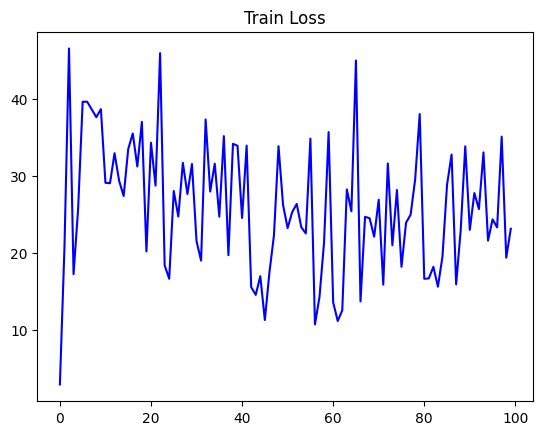

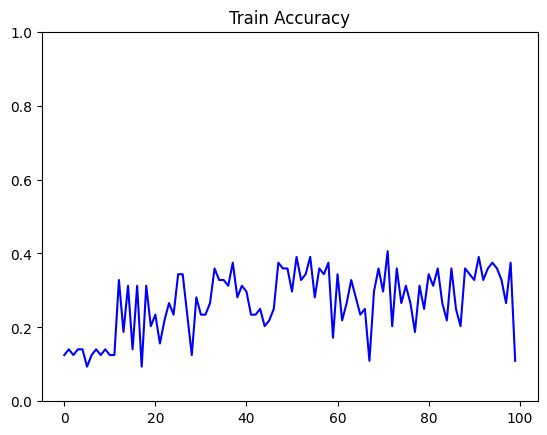

In [172]:
plt.figure(1)
plt.plot(torch.arange(epochs), trainlosses,"b-")
plt.title("Train Loss")

plt.figure(2)
plt.plot(torch.arange(epochs), trainaccs,"b-")
plt.ylim([0.0,1])
plt.title("Train Accuracy")

### Training with all the training set

In [312]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [314]:
epochs = 10
lr = 1.0
mlp = MLP(28*28, [100,10])
mseloss = CELoss()
trainlosses, testlosses = [],[]
trainaccs, testaccs = [],[]

for epoch in range(epochs):
    trainloss, trainacc = train_epoch(mlp, mseloss, train_loader, lr)
    testloss, testacc = test_epoch(mlp, mseloss, test_loader)
    trainlosses.append(trainloss)
    testlosses.append(testloss)
    trainaccs.append(trainacc)
    testaccs.append(testacc)
    print(f"Epoch: {epoch}, Train Accuracy: {(100*trainacc):>0.1f}%, Train Loss: {trainloss:>8f}, Test Accuracy: {(100*testacc):>0.1f}%, Test Loss: {testloss:>8f}")

Epoch: 0, Train Accuracy: 20.6%, Train Loss:      inf, Test Accuracy: 18.2%, Test Loss:      inf


RuntimeError: The size of tensor a (10) must match the size of tensor b (9) at non-singleton dimension 1

Text(0.5, 1.0, 'Accuracy')

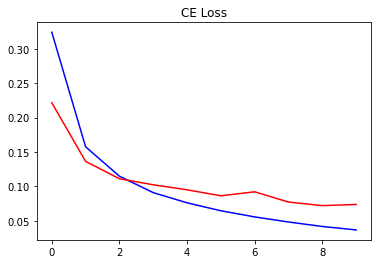

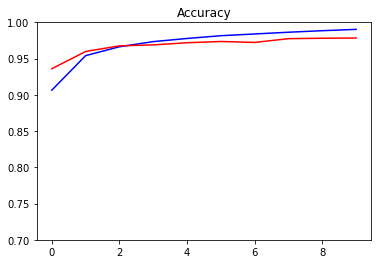

In [23]:
plt.figure(1)
plt.plot(torch.arange(epochs), trainlosses,"b-")
plt.plot(torch.arange(epochs), testlosses,"r-")
plt.title("CE Loss")

plt.figure(2)
plt.plot(torch.arange(epochs), trainaccs,"b-")
plt.plot(torch.arange(epochs), testaccs,"r-")
plt.ylim([0.7,1])
plt.title("Accuracy")
